In [ ]:
# default_exp examples00

In [ ]:
#hide
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#hide
!pip install nbdev
!pip install fastcore

In [ ]:
#hide
% cd /content/drive/My\ Drive/fa_convnav

/content/drive/My Drive/fa_convnav


In [ ]:
#hide
#not deps but we need them to use nbdev and run tests
from nbdev import * 
from nbdev.showdoc import *
from fastcore.test import *

# Examples00

> Examples of fa_convnav usage.

In [ ]:
!pip install fastai2

In [ ]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from torch import torch
from fa_convnav.navigator import *

In [ ]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.jpg$'),
                 item_tfms=Resize(460),
                 batch_tfms=[*aug_transforms(size=224, max_rotate=30, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])

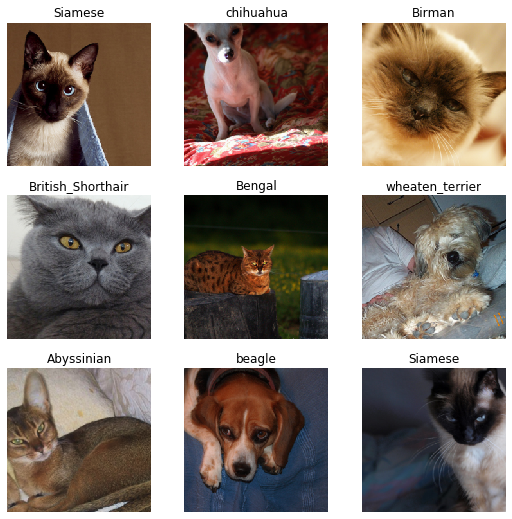

In [ ]:
dls = pets.dataloaders(untar_data(URLs.PETS)/"images",  bs=128)
dls.show_batch(max_n=9)

In [ ]:
model = resnet50

In [ ]:
# hide
# temp fix to model downloading issue
#!cd /root/.cache/torch/checkpoints && curl -O https://download.pytorch.org/models/resnet50-19c8e357.pth

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 97.7M  100 97.7M    0     0  20.7M      0  0:00:04  0:00:04 --:--:-- 20.7M


In [ ]:
learn = cnn_learner(
    dls, 
    model, 
    opt_func=partial(Adam, lr=slice(3e-3), wd=0.01, eps=1e-8), 
    metrics=error_rate, 
    config=cnn_config(ps=0.33)).to_fp16()

In [ ]:
cn = ConvNav(learn, layer_info(learn))

In [ ]:
print(cn.model_info)

Resnet: Resnet50
Input shape: [128, 3, 224, 224] (bs, ch, h, w)
Output features: [128, 37] (bs, classes)
Currently frozen to parameter group 3 out of 3


In [ ]:
cn.divs

Resnet50
Divisions:  body (0), head (1)



,Layer_name,Model,Division,Child modules,Blocks,Layers,Torch_class,Output_dimensions,Parameters,Trainable,Currently
Index,,,,,,,,,,,
1,0,resnet50,Sequential,8,16,128,torch.nn.modules.container.Sequential,"[128, 2048, 7, 7]",23508032,,Frozen
150,1,resnet50,Sequential,9,0,10,torch.nn.modules.container.Sequential,"[128, 37]",2125312,,


In [ ]:
cn.view(top=True)

,Layer_name,Model,Division,Module,Block,Layer_description,Torch_class,Output_dimensions,Parameters,Trainable,Currently
Index,,,,,,,,,,,
0,,Sequential,,,,,torch.nn.modules.container.Sequential,,,,
1,0,,Sequential,,,,torch.nn.modules.container.Sequential,,,,
2,0.0,,,Conv2d,,"Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)",torch.nn.modules.conv.Conv2d,"[128, 64, 112, 112]",9408,False,Frozen
3,0.1,,,BatchNorm2d,,"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",torch.nn.modules.batchnorm.BatchNorm2d,"[128, 64, 112, 112]",128,True,
4,0.2,,,ReLU,,ReLU(inplace=True),torch.nn.modules.activation.ReLU,"[128, 64, 112, 112]",0,False,
5,0.3,,,MaxPool2d,,"MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)",torch.nn.modules.pooling.MaxPool2d,"[128, 64, 56, 56]",0,False,
6,0.4,,,Sequential,,,torch.nn.modules.container.Sequential,,,,
7,0.4.0,,,,Bottleneck,,torchvision.models.resnet.Bottleneck,,,,
8,0.4.0.conv1,,,,,"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)",torch.nn.modules.conv.Conv2d,"[128, 64, 56, 56]",4096,False,Frozen


...152 more layers


In [ ]:
cn.head

Resnet: Resnet50
Input shape: [128, 2048, 7, 7] (bs, filt, h, w)
Output features: [128, 37] (bs, classes)



,Layer_name,Model,Division,Module,Block,Layer_description,Torch_class,Output_dimensions,Parameters,Trainable
Index,,,,,,,,,,
150,1,,Sequential,,,,torch.nn.modules.container.Sequential,,,
151,1.0,,,AdaptiveConcatPool2d,,,fastai2.layers.AdaptiveConcatPool2d,,,
152,1.0.ap,,,,,AdaptiveAvgPool2d(output_size=1),torch.nn.modules.pooling.AdaptiveAvgPool2d,"[128, 2048, 1, 1]",0,False
153,1.0.mp,,,,,AdaptiveMaxPool2d(output_size=1),torch.nn.modules.pooling.AdaptiveMaxPool2d,"[128, 2048, 1, 1]",0,False
154,1.1,,,Flatten,,full: False,fastai2.layers.Flatten,"[128, 4096]",0,False
155,1.2,,,BatchNorm1d,,"BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",torch.nn.modules.batchnorm.BatchNorm1d,"[128, 4096]",8192,True
156,1.3,,,Dropout,,"Dropout(p=0.165, inplace=False)",torch.nn.modules.dropout.Dropout,"[128, 4096]",0,False
157,1.4,,,Linear,,"Linear(in_features=4096, out_features=512, bias=False)",torch.nn.modules.linear.Linear,"[128, 512]",2097152,True
158,1.5,,,ReLU,,ReLU(inplace=True),torch.nn.modules.activation.ReLU,"[128, 512]",0,False


In [ ]:
layers = cn.dim_transitions
layers

Resnet50
Layer dimension changes



,Layer_name,Model,Division,Module,Block,Layer_description,Torch_class,Output_dimensions,Parameters,Trainable,Currently
Index,,,,,,,,,,,
2,0.0,,0,Conv2d,,"Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)",torch.nn.modules.conv.Conv2d,"[128, 64, 112, 112]",9408,False,Frozen
8,0.4.0.conv1,,0,4,0,"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)",torch.nn.modules.conv.Conv2d,"[128, 64, 56, 56]",4096,False,Frozen
38,0.5.0.conv2,,0,5,0,"Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)",torch.nn.modules.conv.Conv2d,"[128, 128, 28, 28]",147456,False,Frozen
74,0.6.0.conv2,,0,6,0,"Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)",torch.nn.modules.conv.Conv2d,"[128, 256, 14, 14]",589824,False,Frozen
126,0.7.0.conv2,,0,7,0,"Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)",torch.nn.modules.conv.Conv2d,"[128, 512, 7, 7]",2359296,False,Frozen


[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)]